In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from load_util import load_util
from plot_util import plot_util
from pred_util import pred_util
import os
data_folder = os.path.join('..', 'data')
file_name = "Data"

# Match Predictor

Predicting the outcome of a football match is a core problem within the sports betting industry. The goal of a betting company is to produce odds that accurately reflect the probable outcome of the match, in order to maintain a healthy profit margin. Predicting an outcome of a sports match is an inheently unceraint task, as the outcome is highly dependent on indivdual coincidences and random events. As a result, it is more relevant to predict the probability of a certain outcome, rather than the outcome itself.

Predicting odds for a home win, draw and a away win is highly difficult. In order to limit the scope, we instead choose to predict if the home team wins, or not, with a binary representation. This is a more manageable problem, and can be extended to predicting the probability of a draw or an away win at a later stage. To implement a predictor and evaluate it, we will aim to create a model which can assign a probibility of Home Victory, and use this percentage to make a choice of whether it would bet on the home team or not.

Initially, the probability of the home team winning is 33%, by a random pick. Our goal is to create a model that can predict the outcome of a match with a higher accuracy than this. To do this we will use historic data about previous matches.

## The Dataset

The dataset we will be using is the last 20 years of football matches from the top four divisions of the english league system. The reasoning behind this choice is to limit the variance of teams in the data. Most of the teams in the top four division will stay within this range, and the data will be easier to handle. The last 20 years give us a dataset of about 40 000 games, which should be enough to train a model on. The data is fetched from the [football-data.co.uk](https://www.football-data.co.uk/englandm.php) website.

In [ ]:
#Fetch the data from the website. This should only be run when there is no file available in the data folder.
leagues = ['E0']
start_year, end_year = 2005, 2024
load_util.fetch_data_into_file(data_folder=data_folder, file_name=file_name, start_year=start_year, end_year=end_year, leagues=leagues)

Data fetched and saved to ../data/Data.csv


## Inspecting the data

Firstly, lets look at the data at hand

In [6]:
data = load_util.load_data(data_folder, file_name)
data.head()


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HC,AC,HY,AY,HR,AR,PSH,PSD,PSA,Season
0,E0,2020-09-12,Fulham,Arsenal,0,3,A,0,1,A,...,2,3,2,2,0,0,6.16,4.51,1.56,2021
1,E0,2020-09-12,Crystal Palace,Southampton,1,0,H,1,0,H,...,7,3,2,1,0,0,3.32,3.29,2.40,2021
2,E0,2020-09-12,Liverpool,Leeds,4,3,H,3,2,H,...,9,0,1,0,0,0,1.31,6.25,9.92,2021
3,E0,2020-09-12,West Ham,Newcastle,0,2,A,0,0,D,...,8,7,2,2,0,0,2.18,3.61,3.50,2021
4,E0,2020-09-13,West Brom,Leicester,0,3,A,0,0,D,...,2,5,1,1,0,0,4.00,3.59,2.00,2021


In [7]:
data.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'PSH', 'PSD', 'PSA', 'Season'],
      dtype='object')

We are given 27 columns, all with different abbreviations. The full names are as follow:
-   Div = League Division
-   Date = Match Date
-   HomeTeam = Home Team
-   AwayTeam = Away Team
-   FTHG = Full Time Home Team Goals
-   FTAG = Full Time Away Team Goals
-   FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
-   HTHG = Half Time Home Team Goals
-   HTAG = Half Time Away Team Goals
-   HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)
-   Referee = Match Referee
-   HS = Home Team Shots
-   AS = Away Team Shots
-   HST = Home Team Shots on Target
-   AST = Away Team Shots on Target
-   HF = Home Team Fouls Committed
-   AF = Away Team Fouls Committed
-   HC = Home Team Corners
-   AC = Away Team Corners
-   HY = Home Team Yellow Cards
-   AY = Away Team Yellow Cards
-   HR = Home Team Red Cards
-   AR = Away Team Red Cards
-   PSH = Pinnacle home win odds
-   PSD = Pinnacle draw odds
-   PSA = Pinnacle away win odds

Some key takeaways to know initially: Teams are either a HomeTeam or AwayTeam for a match. To get all their previous matches, we would have to search within both columns and order by the date. To get all teams however, we would only need to get the unique vlaues of either one of the columns, as all teams have been a HomeTeam or AwayTeam.

Now, lets explore distribution of Home Wins, Draws and Away Wins, as a way to see if the Home team has a statistical advantage

In [16]:
home_factor, draw_factor, away_factor = data['FTR'].value_counts(normalize=True)['H'], data['FTR'].value_counts(normalize=True)['D'], data['FTR'].value_counts(normalize=True)['A']
print(f'The precentage of matches where the home team wins is {home_factor*100:.2f}%\nThe precentage of matches where the match ends in a draw is {draw_factor*100:.2f}%\nThe precentage of matches where the away team wins is {away_factor*100:.2f}%.')

The precentage of matches where the home team wins is 43.66%
The precentage of matches where the match ends in a draw is 22.67%
The precentage of matches where the away team wins is 33.66%.


Already, we now have improved knowledge of the change of the Home team winning the match. Without knowing anything else about the match, we can assert thath the Home Team has a 43.66% change of winning any game. We also know that about 22.67% of matches end in a draw

In the dataset, there are different statistics such as goals, shots, etc., which are split between into two columns, one for the HomeTeam and one for the AwayTeam. Together, the two columns have a key property: They form a Gausian Distribution. For example, the goal differnce between the two teams, which can describe the result of the match, follows a Guassian Distribution 

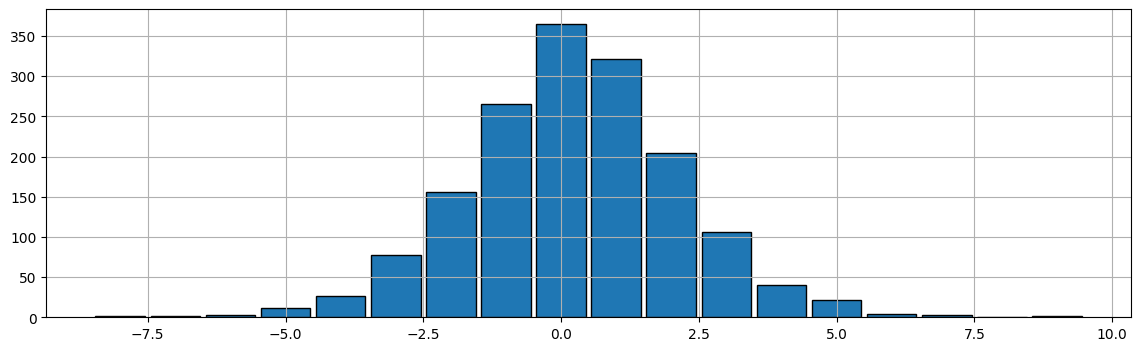

In [24]:
plot_util.plot_histogram(data['FTHG']-data['FTAG'], figsize=figsize)


## Feature Engineering

The presence of the mentioned relationsship means there is an advantage in creating columns to describe this relationship. We create a columns to show the difference, as this is the best way to show the strength difference between the two teams for the match. A positive value means it is favor of the home team, and a negative value means it is in favor of the away team.

In [26]:
data['Goal Difference'] = data['FTHG']-data['FTAG']
data['Shot Difference'] = data['HS']-data['AS']
data['Shot on Target Difference'] = data['HST']-data['AST']
data['Foul Difference'] = data['HF']-data['AF']
data['Corner Difference'] = data['HC']-data['AC']
data['Yellow Card Difference'] = data['HY']-data['AY']
data['Red Card Difference'] = data['HR']-data['AR']
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,PSD,PSA,Season,Goal Difference,Shot Difference,Shot on Target Difference,Foul Difference,Corner Difference,Yellow Card Difference,Red Card Difference
0,E0,2020-09-12,Fulham,Arsenal,0,3,A,0,1,A,...,4.51,1.56,2021,-3,-8,-4,0,-1,0,0
1,E0,2020-09-12,Crystal Palace,Southampton,1,0,H,1,0,H,...,3.29,2.40,2021,1,-4,-2,3,4,1,0
2,E0,2020-09-12,Liverpool,Leeds,4,3,H,3,2,H,...,6.25,9.92,2021,1,16,3,3,9,1,0
3,E0,2020-09-12,West Ham,Newcastle,0,2,A,0,0,D,...,3.61,3.50,2021,-2,0,1,6,1,0,0
4,E0,2020-09-13,West Brom,Leicester,0,3,A,0,0,D,...,3.59,2.00,2021,-3,-6,-6,3,-3,0,0


Now let's see how the differences are distributed

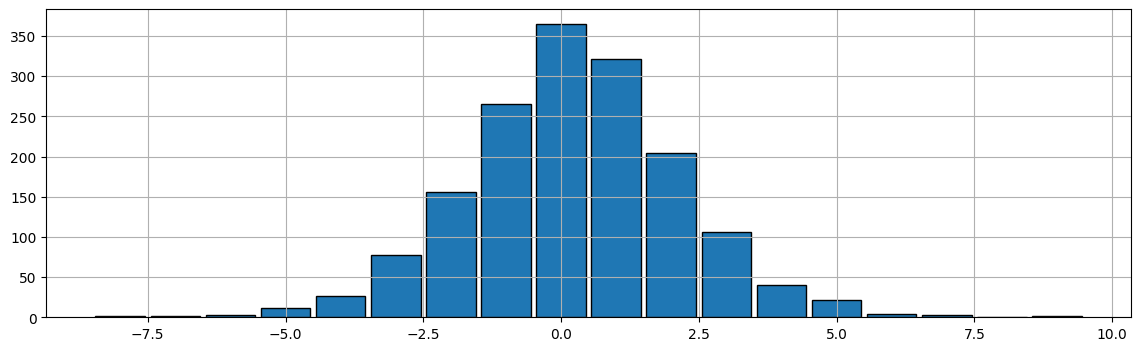

In [27]:
plot_util.plot_histogram(data['Goal Difference'], figsize=figsize)

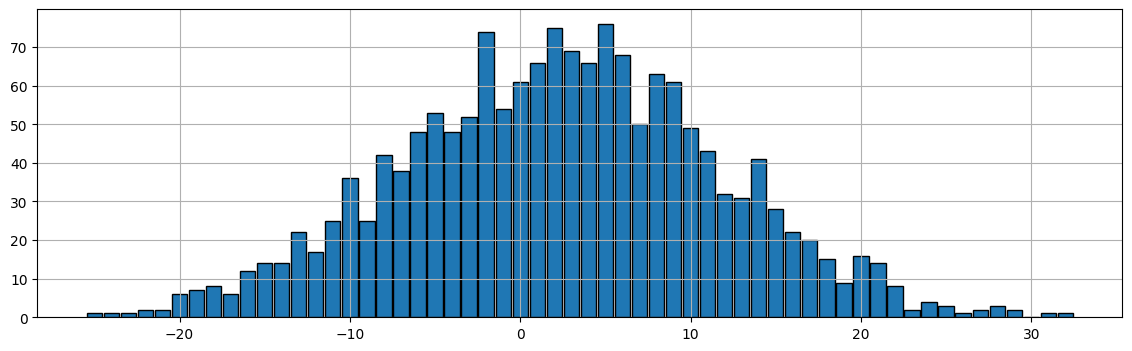

In [29]:
plot_util.plot_histogram(data['Shot Difference'], figsize=figsize)

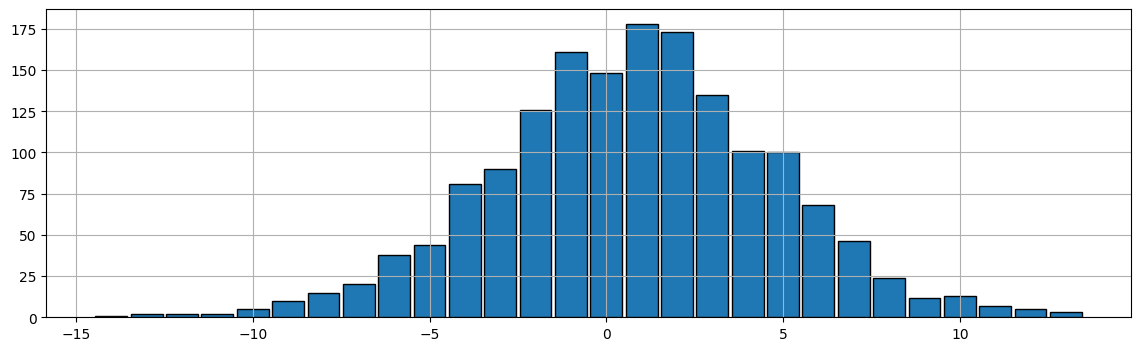

In [30]:
plot_util.plot_histogram(data['Shot on Target Difference'], figsize=figsize)

Lets explore how these columns are distributed and the relationship between them

In [36]:
data_new_cols = data[['Goal Difference', 'Shot Difference', 'Shot on Target Difference', 'Foul Difference', 'Corner Difference', 'Yellow Card Difference', 'Red Card Difference']]
data_new_cols.describe()

,Goal Difference,Shot Difference,Shot on Target Difference,Foul Difference,Corner Difference,Yellow Card Difference,Red Card Difference
count,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000
mean,0.232298,2.321118,0.762733,-0.060870,1.047826,-0.168944,-0.006211
std,1.952054,9.280753,3.973292,4.700742,4.864690,1.686057,0.345384
min,-8.000000,-25.000000,-14.000000,-17.000000,-17.000000,-5.000000,-2.000000
25%,-1.000000,-4.000000,-2.000000,-3.000000,-2.000000,-1.000000,0.000000
50%,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,9.000000,3.000000,3.000000,4.000000,1.000000,0.000000
max,9.000000,32.000000,13.000000,14.000000,17.000000,6.000000,2.000000


In [37]:
data_new_cols.corr()

,Goal Difference,Shot Difference,Shot on Target Difference,Foul Difference,Corner Difference,Yellow Card Difference,Red Card Difference
Goal Difference,1.000000,0.420896,0.656975,-0.072691,0.156428,-0.157452,-0.179459
Shot Difference,0.420896,1.000000,0.741920,-0.062904,0.664816,-0.196114,-0.230884
Shot on Target Difference,0.656975,0.741920,1.000000,-0.042768,0.444573,-0.169175,-0.196722
Foul Difference,-0.072691,-0.062904,-0.042768,1.000000,-0.045750,0.292605,0.033836
Corner Difference,0.156428,0.664816,0.444573,-0.045750,1.000000,-0.129875,-0.163690
Yellow Card Difference,-0.157452,-0.196114,-0.169175,0.292605,-0.129875,1.000000,-0.050897
Red Card Difference,-0.179459,-0.230884,-0.196722,0.033836,-0.163690,-0.050897,1.000000


The correlation shows e.g. how a team is more likely to loose if they have more red cards, or how a team is more likely to win if they have more shots on target. This is a good way to see how the different statistics are related to each other, and how they can be used to predict the outcome of a match. However, the stats only describe the match itself. They are present after the match is played, and cannot be used in advance to predict the outcome. Instead, we must change our approach to use the stats from previous matches to predict the outcome of a future match. We must utilize the sequential nature of the stats to predict the outcome of a coming match. A way to use the full sequence of matches is model the strength of each team by ELO-rating.